<b> RNN with TensorFlow</b>
<br/>
This notebook contains the basic RNN implementation with TensorFlow.

In [1]:
#import and configuration related
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Global config variables
num_steps = 5 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 4
learning_rate = 0.1

In [3]:
#generate dummy data
def gen_data(size=1000000):
    #generate a numpy array of size="size" and with elements in the
    # range (0,2)
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

In [4]:
# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)


In [5]:
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

<b> Model </b>

In [6]:
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [7]:
"""
Definition of rnn_cell

This is very similar to the __call__ method on Tensorflow's BasicRNNCell. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

In [8]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [9]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# Turn our y placeholder into a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

#losses and train_step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [10]:
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 250 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses


EPOCH 0
Average loss at step 100 for last 250 steps: 0.592390707731
Average loss at step 200 for last 250 steps: 0.531126879454
Average loss at step 300 for last 250 steps: 0.522759394646
Average loss at step 400 for last 250 steps: 0.52084880352
Average loss at step 500 for last 250 steps: 0.522119639814
Average loss at step 600 for last 250 steps: 0.521813491881
Average loss at step 700 for last 250 steps: 0.519929710329
Average loss at step 800 for last 250 steps: 0.522535752654
Average loss at step 900 for last 250 steps: 0.518634746075


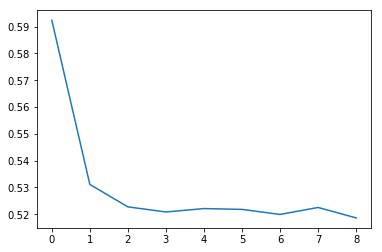

In [11]:
training_losses = train_network(1,num_steps)
plt.plot(training_losses)

In [12]:
'''
import basic_rnn
def plot_learning_curve(num_steps, state_size=4, epochs=1):
    global losses, total_loss, final_state, train_step, x, y, init_state
    tf.reset_default_graph()
    g = tf.get_default_graph()
    losses, total_loss, final_state, train_step, x, y, init_state = \
        basic_rnn.setup_graph(g,
            basic_rnn.RNN_config(num_steps=num_steps, state_size=state_size))
    res = train_network(epochs, num_steps, state_size=state_size, verbose=False)
    plt.plot(res)
'''

'\nimport basic_rnn\ndef plot_learning_curve(num_steps, state_size=4, epochs=1):\n    global losses, total_loss, final_state, train_step, x, y, init_state\n    tf.reset_default_graph()\n    g = tf.get_default_graph()\n    losses, total_loss, final_state, train_step, x, y, init_state =         basic_rnn.setup_graph(g,\n            basic_rnn.RNN_config(num_steps=num_steps, state_size=state_size))\n    res = train_network(epochs, num_steps, state_size=state_size, verbose=False)\n    plt.plot(res)\n'

In [13]:
"""
NUM_STEPS = 1
"""
#plot_learning_curve(num_steps=1, state_size=4, epochs=2)


'\nNUM_STEPS = 1\n'

In [14]:
"""
NUM_STEPS = 10
"""
#plot_learning_curve(num_steps=10, state_size=16, epochs=10)

'\nNUM_STEPS = 10\n'

<b>Transforming to Tensorflow</b>

In [15]:
cell = tf.contrib.rnn.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=init_state)

In [16]:
"""
Predictions, loss, training step
"""
#tf.get_variable_scope().reuse_variables()
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, num=num_steps, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

ValueError: Variable softmax/W already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "C:\Users\rbaral\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1226, in __init__
    self._traceback = _extract_stack()
  File "C:\Users\rbaral\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\rbaral\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 763, in apply_op
    op_def=op_def)


<b> References </b>
<br/>
<ol>
<li> Code and resource credit to <a href="https://r2rt.com/recurrent-neural-networks-in-tensorflow-i.html"> r2rt.com </a> </li>
<li> <a href="https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html"> Written Memories: Understanding, Deriving and Extending the LSTM, on this blog </a> </li>
<li> <a href="http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/">Recurrent Neural Networks Tutorial, by Denny Britz </a> </li>
<li> <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/"> The Unreasonable Effectiveness of Recurrent Neural Networks, by Andrej Karpathy</a> </li>
<li> <a href="http://colah.github.io/posts/2015-08-Understanding-LSTMs/"> Understanding LSTM Networks, by Christopher Olah </a></li>

</ol>